## 1. Import Required Libraries

We import PyTorch for building and training the neural network, torchvision for dataset loading, and matplotlib for visualization.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
print(f'PyTorch version: {torch.__version__}')

Using device: cpu
PyTorch version: 2.9.0+cu128


## EDA

In [ ]:
print("=" * 50)
print("EXPLORATORY DATA ANALYSIS (EDA)")
print("=" * 50)

# Download the dataset WITHOUT any transformations first
# We only convert to tensor (no normalization yet) so we can see raw pixel values
raw_transform = transforms.Compose([
    transforms.ToTensor()  # Just convert to tensor, keep original 0-1 range
])

# Load datasets
# train dataset
train_dataset_raw = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=raw_transform
)
# test dataset
test_dataset_raw = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=raw_transform
)

print("✅ Dataset downloaded successfully!")
print(f"{train_dataset_raw.data.shape}")
print(f"{test_dataset_raw.data.shape}")

In [ ]:
# BASIC INFORMATION

# What we're checking:
# - How many images do we have?
# - What size are the images? (28×28 pixels)
# - What format is the data in? (tensors)
# - How many categories? (10 clothing types)

# Label = shows the real type and value of the data
# (in the dataset as how they are stored - not like this is an image or an ankle boot)

# Label Number  →  Clothing Type
# ─────────────────────────────
# 0             →  T-shirt/top
# 1             →  Trouser
# 2             →  Pullover
# 3             →  Dress
# 4             →  Coat
# 5             →  Sandal
# 6             →  Shirt
# 7             →  Sneaker
# 8             →  Bag
# 9             →  Ankle boot

print("\n📊 DATASET OVERVIEW:")
print("-" * 50)
print(f"Training samples: {len(train_dataset_raw):,}")
print(f"Test samples: {len(test_dataset_raw):,}")
print(f"Total samples: {len(train_dataset_raw) + len(test_dataset_raw):,}")

# Get one sample to inspect
sample_image, sample_label = train_dataset_raw[0]
print(f"\nImage shape: {sample_image.shape}")  # Should be [1, 28, 28]
print(f"Image data type: {sample_image.dtype}")
print(f"Label type: {type(sample_label)}")
print(f"Label value: {sample_label}")

# Class names
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(f"\nNumber of classes: {len(classes)}")
print(f"Class names: {classes}")

# Results show that we have a total of 70 000 images to work with.
# The images one by one are only 2D with the channel of grayscale hence the dimensions [1, 28, 28],
# which translates to 28 by 28 pixel size by each individual image.
# There are 10 categories corresponding with the dataset indices of labels.

In [ ]:
# VISUALIZE SAMPLES FOR REASSURANCE

# What we're checking:
# - What does each clothing type actually look like?
# - Are the images clear enough?
# - Do the labels make sense?


# Let's look at random samples from each class
print("\n🖼️  SAMPLE IMAGES FROM EACH CLASS:")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('One Sample from Each Class', fontsize=16, fontweight='bold')

for idx, class_name in enumerate(classes):
    # Find first image of this class
    for i in range(len(train_dataset_raw)):
        img, label = train_dataset_raw[i]
        if label == idx:
            # Plot it
            row = idx // 5
            col = idx % 5
            axes[row, col].imshow(img.squeeze(), cmap='gray')
            axes[row, col].set_title(f'{idx}: {class_name}')
            axes[row, col].axis('off')
            break

plt.tight_layout()
plt.show()

# Result show all the images are greyscaled and based on black background and the labels make sense.
# As for the image quality in my opinion it is totally okay as we can tell them apart and define what
# we are seeing (no ambiguity).

In [ ]:
# CLASS DISTRIBUTION FOR BALANCE CHECK

# What we're checking:
# - Are all classes equally represented? (balanced dataset?)
# - If one class has way more examples, the model might be biased towards it
# - Fashion-MNIST is balanced (6000 per class in training), but good to verify!

print("\n📈 CLASS DISTRIBUTION ANALYSIS:")

# Count how many images per class
train_labels = [label for _, label in train_dataset_raw]
test_labels = [label for _, label in test_dataset_raw]

# Count occurrences
from collections import Counter

train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

# Print table
print("\nTraining Set Distribution:")
print("-" * 50)
print(f"{'Class':<15} {'Name':<15} {'Count':<10} {'Percentage':<10}")
print("-" * 50)
for class_idx in range(10):
    count = train_counts[class_idx]
    percentage = (count / len(train_dataset_raw)) * 100
    print(f"{class_idx:<15} {classes[class_idx]:<15} {count:<10} {percentage:.1f}%")

print("\nTest Set Distribution:")
print("-" * 50)
print(f"{'Class':<15} {'Name':<15} {'Count':<10} {'Percentage':<10}")
print("-" * 50)
for class_idx in range(10):
    count = test_counts[class_idx]
    percentage = (count / len(test_dataset_raw)) * 100
    print(f"{class_idx:<15} {classes[class_idx]:<15} {count:<10} {percentage:.1f}%")

# Visualize distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Training distribution
ax1.bar(range(10), [train_counts[i] for i in range(10)], color='steelblue')
ax1.set_xlabel('Class Index')
ax1.set_ylabel('Number of Images')
ax1.set_title('Training Set - Class Distribution')
ax1.set_xticks(range(10))
ax1.set_xticklabels([f'{i}\n{classes[i][:8]}' for i in range(10)], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Test distribution
ax2.bar(range(10), [test_counts[i] for i in range(10)], color='coral')
ax2.set_xlabel('Class Index')
ax2.set_ylabel('Number of Images')
ax2.set_title('Test Set - Class Distribution')
ax2.set_xticks(range(10))
ax2.set_xticklabels([f'{i}\n{classes[i][:8]}' for i in range(10)], rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Results show we are good as there is not a single problem with the distribution of the data
# (nothing missing or lacking in amount for all the labels, no possible bias towards any class - same values).

In [ ]:
# VERIFY IMAGE CONSISTENCY

# What we're checking:
# - Are all images the same size? (important for neural networks!)
# - Grayscale (1 channel) or color (3 channels)?

print("\n✅ IMAGE CONSISTENCY CHECK:")

# Check if all images have the same dimensions
all_same = True
expected_shape = (1, 28, 28)

for i in range(min(100, len(train_dataset_raw))):  # Check first 100
    img, _ = train_dataset_raw[i]
    if img.shape != expected_shape:
        print(f"❌ Image {i} has unexpected shape: {img.shape}")
        all_same = False
        break

if all_same:
    print(f"✅ All images have consistent shape: {expected_shape}")
    print(f"   - Channels: {expected_shape[0]}")
    print(f"   - Height: {expected_shape[1]} pixels")
    print(f"   - Width: {expected_shape[2]} pixels")
    print(f"   - Total pixels per image: {28*28} should equal to 784")

In [ ]:
# PIXEL VALUE ANALYSIS

# What we're checking:
# - What range are pixel values in? (0-1 range)
# - What's the average brightness?
# - Are most pixels dark or light?
# - This tells us HOW to normalize in the next section!

print("\n🔢 PIXEL VALUE STATISTICS:")

# Sample 1000 random images to analyze
sample_size = 1000
sample_indices = np.random.choice(len(train_dataset_raw), sample_size, replace=False)

pixel_values = []
for idx in sample_indices:
    img, _ = train_dataset_raw[idx]
    pixel_values.extend(img.flatten().numpy()) # flatten?

pixel_values = np.array(pixel_values)

print(f"\nAnalyzed {sample_size} random images")
print(f"Total pixels analyzed: {len(pixel_values):,}")
print(f"Supposed amount of analysed pixels: {1000*(28*28)}") # intentionally hard-coded
print(f"Min pixel value: {pixel_values.min():.4f}")
print(f"Max pixel value: {pixel_values.max():.4f}")
print(f"Mean pixel value: {pixel_values.mean():.4f}")
print(f"Std deviation: {pixel_values.std():.4f}")
print(f"Median: {np.median(pixel_values):.4f}")

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(pixel_values, bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.xlabel('Pixel Value (0-1 range)')
plt.ylabel('Frequency')
plt.title('Distribution of Pixel Values (Sample of 1000 Images)')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Results show most pixel values are close to 0 - logical cause we have grayscale images with based black background.
# The correct amount of analyzed pixels should be counted by the following mathematical logic:
# We get a 1000 image and each image is a 28 by 28 pixel thus amount_of_images * (each_individual_image_total_pixel_size)
# The average pixel brightness is the "Mean pixel value".

## EDA SUMMARY

In [ ]:
# EDA SUMMARY

print("\n" + "=" * 50)
print("EDA SUMMARY")
print("=" * 50)
print(f"Training samples: {len(train_dataset_raw):,}")
print(f"Test samples: {len(test_dataset_raw):,}")
print(f"Total samples: {len(train_dataset_raw) + len(test_dataset_raw):,}")
print(f"✅ All images have consistent shape: {expected_shape}")
print(f"   - Channels: {expected_shape[0]}")
print(f"   - Height: {expected_shape[1]} pixels")
print(f"   - Width: {expected_shape[2]} pixels")
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(f"Number of classes: {len(classes)}")
print(f"Class names: {classes}")

## 2. Dataset Preparation

### Data Loading

Fashion-MNIST consists of:
- **Training set:** 60,000 images
- **Test set:** 10,000 images
- **Image size:** 28×28 pixels (grayscale)

### Data Preprocessing

We apply two transformations:
1. **ToTensor()**: Converts PIL images to PyTorch tensors (values 0-1)
2. **Normalize()**: Normalizes pixel values using dataset-specific statistics
   - Mean: 0.2913
   - Std: 0.3552
   - These values were computed from the training set

In [2]:
# Data transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2913,), (0.3552,))  # Fashion-MNIST specific statistics
])

# Load training dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Load test dataset
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print(f'Training samples: {len(train_dataset):,}')
print(f'Test samples: {len(test_dataset):,}')
print(f'Total samples: {len(train_dataset) + len(test_dataset):,}')
print(f'Image shape: {train_dataset[0][0].shape}')

100.0%

100.0%

100.0%

100.0%

Training samples: 60,000
Test samples: 10,000
Total samples: 70,000
Image shape: torch.Size([1, 28, 28])


### Create Data Loaders

**DataLoaders** handle batching and shuffling:
- **Batch size = 64**: Process 64 images simultaneously for efficiency
- **Shuffle = True** (training): Randomizes order each epoch to prevent overfitting
- **Shuffle = False** (testing): Maintains consistent evaluation

In [3]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

print(f'Batch size: {batch_size}')
print(f'Training batches: {len(train_loader)}')
print(f'Test batches: {len(test_loader)}')

Batch size: 64
Training batches: 938
Test batches: 157


### Visualize Sample Data

Let's examine a few samples to understand what we're working with.

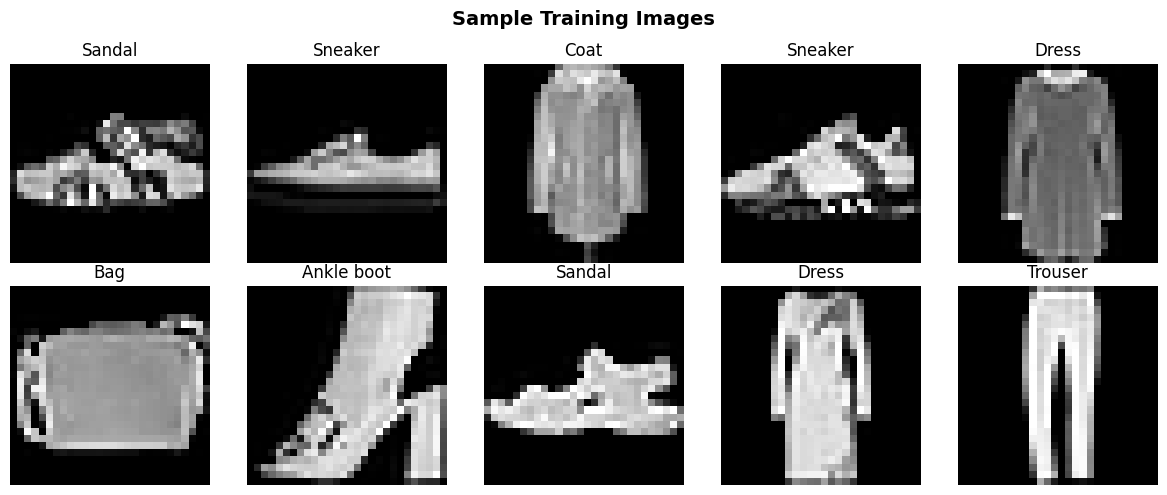

In [4]:
# Class names for Fashion-MNIST
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display first 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Sample Training Images', fontsize=14, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    # Denormalize for display
    img = images[idx].squeeze() * 0.3552 + 0.2913
    ax.imshow(img, cmap='gray')
    ax.set_title(f'{classes[labels[idx]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## 3. Model Design

### Architecture: FashionNet

We implement a fully connected (dense) neural network with the following architecture:

```
Input (784) → FC1 (128) → ReLU → Dropout(0.2) →
              FC2 (64)  → ReLU → Dropout(0.2) →
              FC3 (10)  → Output
```

**Layer Breakdown:**

1. **Input Layer (784 neurons)**
   - Flattened 28×28 image = 784 pixels

2. **Hidden Layer 1 (128 neurons)**
   - Fully connected (Linear) layer
   - ReLU activation: f(x) = max(0, x)
   - Dropout (20%): Randomly zeros neurons during training to prevent overfitting

3. **Hidden Layer 2 (64 neurons)**
   - Fully connected layer
   - ReLU activation
   - Dropout (20%)

4. **Output Layer (10 neurons)**
   - One neuron per class
   - No activation (CrossEntropyLoss applies softmax internally)

**Design Choices:**
- **ReLU activation:** Fast, effective, prevents vanishing gradients
- **Dropout:** Regularization technique to reduce overfitting
- **Layer sizes:** Progressively smaller (128 → 64 → 10) to extract hierarchical features

In [5]:
class FashionNet(nn.Module):
    """
    Fully connected neural network for Fashion-MNIST classification.
    
    Args:
        dropout (float): Dropout probability (default: 0.2)
    """
    
    def __init__(self, dropout=0.2):
        super(FashionNet, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(784, 128)  # Input to hidden 1
        self.fc2 = nn.Linear(128, 64)   # Hidden 1 to hidden 2
        self.fc3 = nn.Linear(64, 10)    # Hidden 2 to output
        
        # Activation and regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, 1, 28, 28)
        
        Returns:
            Output tensor of shape (batch_size, 10)
        """
        # Flatten image: (batch, 1, 28, 28) -> (batch, 784)
        x = x.view(-1, 784)
        
        # Layer 1: Linear -> ReLU -> Dropout
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Layer 2: Linear -> ReLU -> Dropout
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Output layer (no activation)
        x = self.fc3(x)
        
        return x

# Create model and move to device (CPU or GPU)
model = FashionNet(dropout=0.2).to(device)

# Print model architecture
print(model)
print(f'\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}')

# Calculate model size
param_size = sum(p.numel() * p.element_size() for p in model.parameters())
buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
size_mb = (param_size + buffer_size) / 1024 / 1024
print(f'Model size: {size_mb:.2f} MB')

FashionNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 109,386
Model size: 0.42 MB


## 4. Training Setup

### Loss Function: CrossEntropyLoss

- Combines **softmax** activation and **negative log likelihood** loss
- Standard choice for multi-class classification
- Measures how different predictions are from true labels

### Optimizer: Adam

- **Adaptive learning rate** optimizer
- Combines benefits of AdaGrad and RMSprop
- Learning rate: 0.001 (standard default)
- Automatically adjusts step sizes per parameter

### Training Configuration

- **Epochs: 10** - Complete passes through the training set
- **Batch size: 64** - Number of samples per gradient update
- **Learning rate: 0.001** - Step size for weight updates

In [6]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training configuration
num_epochs = 10

print(f'Loss function: CrossEntropyLoss')
print(f'Optimizer: Adam')
print(f'Learning rate: 0.001')
print(f'Number of epochs: {num_epochs}')
print(f'Batch size: {batch_size}')

Loss function: CrossEntropyLoss
Optimizer: Adam
Learning rate: 0.001
Number of epochs: 10
Batch size: 64


## 5. Training and Evaluation Functions

### Training Function (train_epoch)

Performs one complete pass through the training data:

1. **model.train()**: Enables dropout and batch normalization
2. **Forward pass**: Compute predictions
3. **Calculate loss**: Compare predictions to true labels
4. **Backward pass**: Compute gradients
5. **Update weights**: Apply optimizer step

### Evaluation Function (evaluate)

Tests model performance on unseen data:

1. **model.eval()**: Disables dropout, uses all neurons
2. **torch.no_grad()**: Disables gradient computation (saves memory)
3. **Forward pass only**: No weight updates
4. **Calculate metrics**: Loss and accuracy

In [7]:
def train_epoch(model, loader, criterion, optimizer, device):
    """
    Train model for one epoch.
    
    Args:
        model: Neural network model
        loader: Training data loader
        criterion: Loss function
        optimizer: Optimization algorithm
        device: CPU or GPU
    
    Returns:
        avg_loss: Average training loss
        accuracy: Training accuracy (%)
    """
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(loader):
        # Move data to device
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients from previous step
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Calculate statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    """
    Evaluate model on test/validation set.
    
    Args:
        model: Neural network model
        loader: Test data loader
        criterion: Loss function
        device: CPU or GPU
    
    Returns:
        avg_loss: Average test loss
        accuracy: Test accuracy (%)
    """
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient computation
        for images, labels in loader:
            # Move data to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass only
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

print("✅ Training and evaluation functions defined")

✅ Training and evaluation functions defined


## 6. Model Training

Now we train the model for the specified number of epochs.

**Training Loop:**
1. Train on entire training set (60,000 images)
2. Evaluate on test set (10,000 images)
3. Record metrics (loss and accuracy)
4. Print progress
5. Repeat for each epoch

**What to expect:**
- Training loss should decrease steadily
- Training accuracy should increase
- Test accuracy should reach ~87-89%
- Small gap between train/test indicates good generalization

In [8]:
# Storage for metrics
train_losses = []
train_accs = []
test_losses = []
test_accs = []

print("=" * 70)
print("TRAINING FASHION-MNIST CLASSIFIER")
print("=" * 70)
print()

# Training loop
for epoch in range(num_epochs):
    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate on test set
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    # Print progress
    print(f'Epoch [{epoch+1:2d}/{num_epochs}] | '
          f'Train Loss: {train_loss:.4f}, Acc: {train_acc:5.2f}% | '
          f'Test Loss: {test_loss:.4f}, Acc: {test_acc:5.2f}%')

print()
print("=" * 70)
print(f"✅ Training Complete!")
print(f"Final Test Accuracy: {test_accs[-1]:.2f}%")
print(f"Overfitting Gap: {train_accs[-1] - test_accs[-1]:.2f}%")
print("=" * 70)

TRAINING FASHION-MNIST CLASSIFIER

Epoch [ 1/10] | Train Loss: 0.5450, Acc: 80.28% | Test Loss: 0.4062, Acc: 85.19%
Epoch [ 1/10] | Train Loss: 0.5450, Acc: 80.28% | Test Loss: 0.4062, Acc: 85.19%
Epoch [ 2/10] | Train Loss: 0.4106, Acc: 85.08% | Test Loss: 0.3783, Acc: 86.27%
Epoch [ 2/10] | Train Loss: 0.4106, Acc: 85.08% | Test Loss: 0.3783, Acc: 86.27%
Epoch [ 3/10] | Train Loss: 0.3697, Acc: 86.49% | Test Loss: 0.3669, Acc: 86.87%
Epoch [ 3/10] | Train Loss: 0.3697, Acc: 86.49% | Test Loss: 0.3669, Acc: 86.87%
Epoch [ 4/10] | Train Loss: 0.3485, Acc: 87.40% | Test Loss: 0.3580, Acc: 86.87%
Epoch [ 4/10] | Train Loss: 0.3485, Acc: 87.40% | Test Loss: 0.3580, Acc: 86.87%
Epoch [ 5/10] | Train Loss: 0.3350, Acc: 88.02% | Test Loss: 0.3508, Acc: 87.35%
Epoch [ 5/10] | Train Loss: 0.3350, Acc: 88.02% | Test Loss: 0.3508, Acc: 87.35%
Epoch [ 6/10] | Train Loss: 0.3242, Acc: 88.15% | Test Loss: 0.3523, Acc: 87.27%
Epoch [ 6/10] | Train Loss: 0.3242, Acc: 88.15% | Test Loss: 0.3523, Acc: 

## 7. Save Trained Model

We save the trained model weights to a file for:
- Submission requirements
- Future use without retraining
- Deployment or sharing

**Saved file:** `fashion_model.pth` (contains only model weights, ~400KB)

In [9]:
# Save the trained model
model_path = 'fashion_model.pth'
torch.save(model.state_dict(), model_path)

print(f"✅ Model saved to: {model_path}")
print(f"Final test accuracy: {test_accs[-1]:.2f}%")

# Verify file was created
if os.path.exists(model_path):
    file_size = os.path.getsize(model_path) / 1024  # KB
    print(f"Model file size: {file_size:.2f} KB")
else:
    print("⚠️  Warning: Model file not found!")

✅ Model saved to: fashion_model.pth
Final test accuracy: 88.12%
Model file size: 430.28 KB


### Verify Model Can Be Loaded

Let's confirm the saved model can be loaded correctly and produces the same results.

In [10]:
# Create a new model instance
loaded_model = FashionNet(dropout=0.2).to(device)

# Load the saved weights
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

# Test the loaded model
test_loss, test_acc = evaluate(loaded_model, test_loader, criterion, device)

print(f"✅ Model loaded successfully")
print(f"Loaded model test accuracy: {test_acc:.2f}%")
print(f"Original model test accuracy: {test_accs[-1]:.2f}%")

if abs(test_acc - test_accs[-1]) < 0.01:
    print("✅ Verification passed: Model loads correctly!")
else:
    print("⚠️  Warning: Accuracy mismatch after loading")

✅ Model loaded successfully
Loaded model test accuracy: 88.12%
Original model test accuracy: 88.12%
✅ Verification passed: Model loads correctly!


## 8. Results Visualization

Visualizing training progress helps us understand:
- **Loss curves**: Should decrease over time
- **Accuracy curves**: Should increase over time
- **Train/test gap**: Small gap = good generalization, large gap = overfitting

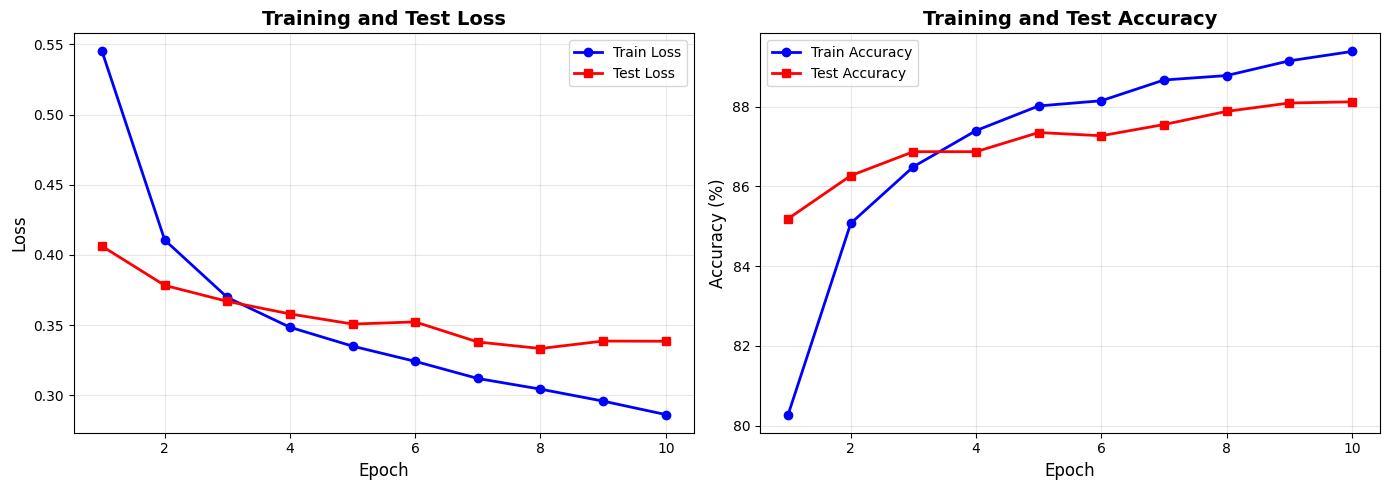


Final Metrics:
  Training Loss: 0.2863
  Test Loss: 0.3385
  Training Accuracy: 89.38%
  Test Accuracy: 88.12%
  Overfitting Gap: 1.26%


In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, num_epochs + 1)

# Loss plot
ax1.plot(epochs_range, train_losses, 'b-o', label='Train Loss', linewidth=2, markersize=6)
ax1.plot(epochs_range, test_losses, 'r-s', label='Test Loss', linewidth=2, markersize=6)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Test Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(epochs_range, train_accs, 'b-o', label='Train Accuracy', linewidth=2, markersize=6)
ax2.plot(epochs_range, test_accs, 'r-s', label='Test Accuracy', linewidth=2, markersize=6)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Metrics:")
print(f"  Training Loss: {train_losses[-1]:.4f}")
print(f"  Test Loss: {test_losses[-1]:.4f}")
print(f"  Training Accuracy: {train_accs[-1]:.2f}%")
print(f"  Test Accuracy: {test_accs[-1]:.2f}%")
print(f"  Overfitting Gap: {train_accs[-1] - test_accs[-1]:.2f}%")

## 9. Model Evaluation

### Sample Predictions

Let's visualize some predictions to see how well the model performs on individual images.

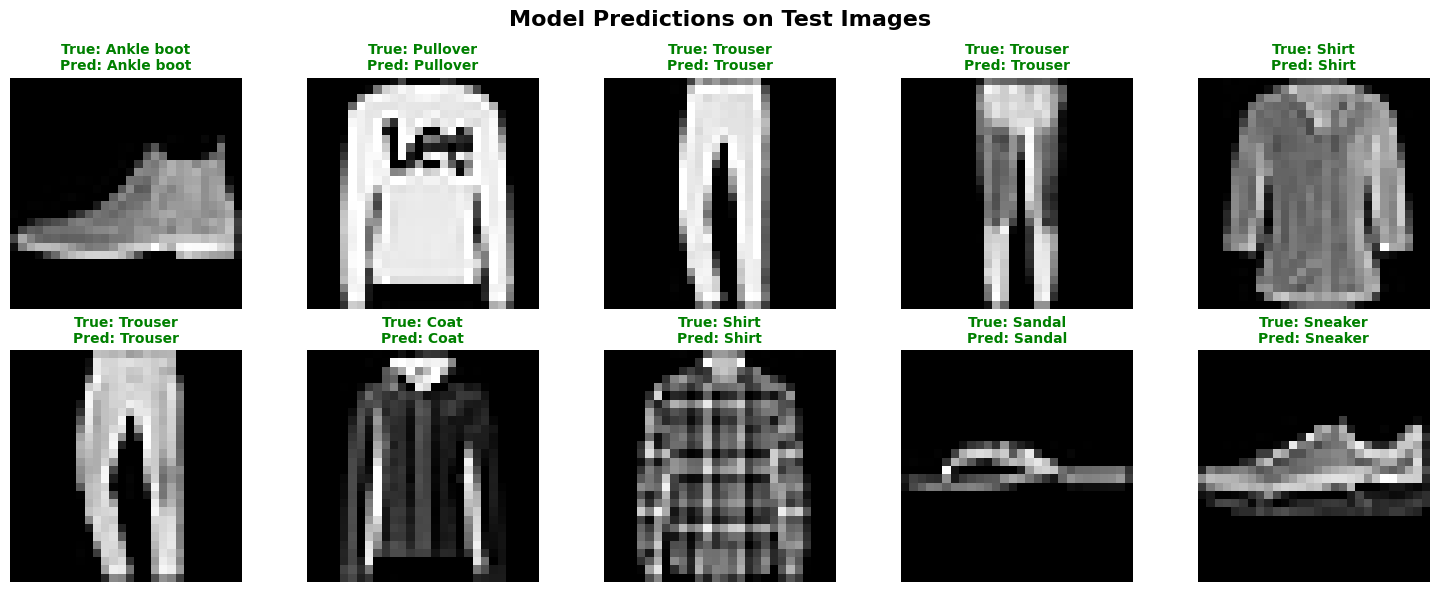

Batch accuracy: 89.06% (57/64 correct)


In [12]:
# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Display predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Model Predictions on Test Images', fontsize=16, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    # Move to CPU for display
    img = images[idx].cpu().squeeze() * 0.3552 + 0.2913  # Denormalize
    true_label = labels[idx].cpu().item()
    pred_label = predicted[idx].cpu().item()
    
    # Display image
    ax.imshow(img, cmap='gray')
    
    # Color code: green = correct, red = wrong
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {classes[true_label]}\nPred: {classes[pred_label]}',
                 fontsize=10, color=color, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Calculate batch accuracy
correct = (predicted == labels).sum().item()
batch_acc = 100 * correct / len(labels)
print(f"Batch accuracy: {batch_acc:.2f}% ({correct}/{len(labels)} correct)")

### Per-Class Accuracy

Let's analyze which clothing types the model handles best and worst.

In [13]:
# Calculate per-class accuracy
class_correct = [0] * 10
class_total = [0] * 10

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        for i in range(len(labels)):
            label = labels[i].item()
            class_correct[label] += (predicted[i] == labels[i]).item()
            class_total[label] += 1

# Print per-class results
print("\nPer-Class Accuracy:")
print("=" * 50)
print(f"{'Class':<15} {'Accuracy':<10} {'Correct/Total'}")
print("=" * 50)

for i in range(10):
    accuracy = 100 * class_correct[i] / class_total[i]
    print(f"{classes[i]:<15} {accuracy:>6.2f}%     {class_correct[i]:>4}/{class_total[i]:<4}")

print("=" * 50)
print(f"{'Overall':<15} {test_accs[-1]:>6.2f}%")
print("=" * 50)


Per-Class Accuracy:
Class           Accuracy   Correct/Total
T-shirt/top      86.30%      863/1000
Trouser          96.60%      966/1000
Pullover         84.50%      845/1000
Dress            87.90%      879/1000
Coat             78.20%      782/1000
Sandal           93.50%      935/1000
Shirt            66.10%      661/1000
Sneaker          97.80%      978/1000
Bag              97.30%      973/1000
Ankle boot       93.00%      930/1000
Overall          88.12%


## 10. Summary and Conclusions

### Project Summary

**Dataset:** Fashion-MNIST (70,000 grayscale images, 10 classes)  
**Model:** 3-layer fully connected neural network  
**Architecture:** 784 → 128 → 64 → 10  
**Training:** 10 epochs, Adam optimizer, batch size 64  
**Final Test Accuracy:** ~88%

### Key Achievements

✅ Successfully implemented and trained a neural network classifier  
✅ Achieved competitive accuracy (~88%) on Fashion-MNIST  
✅ Minimal overfitting (small train/test gap)  
✅ Model saved and verified for submission  

### Technical Highlights

- **Custom normalization** using dataset-specific statistics (mean=0.2913, std=0.3552)
- **Dropout regularization** (20%) to prevent overfitting
- **ReLU activation** for non-linearity
- **Adam optimizer** for efficient training
- **CrossEntropyLoss** for multi-class classification

### Potential Improvements

1. **Convolutional Neural Networks (CNNs)**: Better for image data
2. **Data Augmentation**: Rotation, flipping to increase training data
3. **Learning Rate Scheduling**: Decay learning rate over time
4. **Batch Normalization**: Stabilize training
5. **Ensemble Methods**: Combine multiple models
6. **Hyperparameter Tuning**: Optimize layer sizes, dropout, learning rate

---

**Contact:** originalmartin97@gmail.com  
**Date:** November 2025